In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import scipy.ndimage as ndimage

def lamb2shift(lamb,ex):
    shift = 1e7/532.15 - 1e7/lamb
    return shift

def find_nearest(array, value,index=False):
    idx = (np.abs(array - value)).argmin()
    if index:
        return idx
    else:
        return array[idx]

class Sample:
    def __init__(self,hdf_file):
        with h5py.File(hdf_file, 'r') as hdf:
            self.data_file = hdf_file
            self.Details =  {i:v for i,v in hdf.attrs.items()}
            self.Measurements = [i for i in hdf.keys()]
            
    def Laser_reflectivity(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/Laser Reflectivity']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
            
        return data,meta
    
    def Ion_probe(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/Ion Probe']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
        return data,meta
    
    def In_situ_Raman(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/Raman']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
        
        return data,meta
    
    def ICCD_images(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/ICCD Imaging']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
            
            return data,meta

In [19]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import scipy.ndimage as ndimage

#CONSTANTS REQUIRED TO GENERATE FEATURES

#ICCD image constants
ICCD_pixel_per_cm = 109.015
substrate_location_pix = (991,438)
pixels_subtrate_probe = 33

def lamb2shift(lamb,ex):
    shift = 1e7/532.15 - 1e7/lamb
    return shift

def find_nearest(array, value,index=False):
    idx = (np.abs(array - value)).argmin()
    if index:
        return idx
    else:
        return array[idx]

class Sample:
    def __init__(self,hdf_file):
        with h5py.File(hdf_file, 'r') as hdf:
            self.data_file = hdf_file
            self.Details =  {i:v for i,v in hdf.attrs.items()}
            self.Measurements = [i for i in hdf.keys()]
            
    def Laser_reflectivity(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/Laser Reflectivity']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
            
        return data,meta
    
    def Ion_probe(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/Ion Probe']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
        return data,meta
    
    def In_situ_Raman(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/Raman']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
        
        return data,meta
    
    def ICCD_images(self):
        with h5py.File(self.data_file, 'r') as hdf:
            g = hdf['In situ Measurements/ICCD Imaging']
            data = np.array(g)
            meta = {i:v for i,v in g.attrs.items()}
            
            return data,meta

def PLD_Sample_Features(sample_hdf5_file, visualize=False):
    sample = Sample(sample_hdf5_file)
    features = {}
    
    if visualize:
        fig, ax = plt.subplots(2,2,figsize=(8,5))
    
    #Flags
    PULSES_FROM_LR = False
    
    ########## Basic Features ##########
    # atmospheric features
    features['Pressure (Torr)'] = np.float64(sample.Details['Pressure (Torr)'])
    features['Gas 1'] = sample.Details['Gas 1']
    if sample.Details['Gas 1 flowrate (sccm)'] != 'None':    
        features['Gas 1 Flowrate (sccm)'] = np.float64(sample.Details['Gas 1 flowrate (sccm)'])
    else:
        features['Gas 1 Flowrate (sccm)'] = None
        
    features['Gas 2'] = sample.Details['Gas 2']
    if sample.Details['Gas 2 flowrate (sccm)'] != 'None':    
        features['Gas 2 Flowrate (sccm)'] = np.float64(sample.Details['Gas 2 flowrate (sccm)'])
    else:
        features['Gas 2 Flowrate (sccm)'] = None
    
    #Excimer laser features
    if sample.Details['Rep Rate 1 (Hz)'] != 'None':       
        features['Rep Rate 1'] = np.float64(sample.Details['Rep Rate 1 (Hz)'])
    else:
        features['Rep Rate 1'] = None
    if sample.Details['Aperture 1 Size (x,y) (mm)'] != 'None':
        features['Aperture 1 Size X (mm)'] = float(sample.Details['Aperture 1 Size (x,y) (mm)'].split(',')[0])
        features['Aperture 1 Size Y (mm)'] = float(sample.Details['Aperture 1 Size (x,y) (mm)'].split(',')[1])
        features['Aperture 1 Area (mm^2)'] = features['Aperture 1 Size X (mm)']*features['Aperture 1 Size Y (mm)']
    else:
        features['Aperture 1 Size X (mm)'] = None
        features['Aperture 1 Size Y (mm)'] = None
        features['Aperture 1 Area (mm^2)'] = None
    if sample.Details['Laser 1 Energy (mJ)'] != 'None':  
        features['Laser 1 Energy (mJ)'] = np.float64(sample.Details['Laser 1 Energy (mJ)'])
    else:
        features['Laser 1 Energy (mJ)'] = None
        
    if sample.Details['Rep Rate 2 (Hz)'] != 'None':       
        features['Rep Rate 2'] = np.float64(sample.Details['Rep Rate 2 (Hz)'])
    else:
        features['Rep Rate 2'] = None
    if sample.Details['Aperture 2 Size (x,y) (mm)'] != 'None':
        features['Aperture 2 Size X (mm)'] = float(sample.Details['Aperture 2 Size (x,y) (mm)'].split(',')[0])
        features['Aperture 2 Size Y (mm)'] = float(sample.Details['Aperture 2 Size (x,y) (mm)'].split(',')[1])
        features['Aperture 2 Area (mm^2)'] = features['Aperture 2 Size X (mm)']*features['Aperture 2 Size Y (mm)']
    else:
        features['Aperture 2 Size X (mm)'] = None
        features['Aperture 2 Size Y (mm)'] = None
        features['Aperture 2 Area (mm^2)'] = None
    if sample.Details['Laser 2 Energy (mJ)'] != 'None':  
        features['Laser 2 Energy (mJ)'] = np.float64(sample.Details['Laser 2 Energy (mJ)'])
    else:
        features['Laser 2 Energy (mJ)'] = None
          
    if sample.Details['Number of Pulses 1'].isnumeric():
        features['Number of pulses 1'] = sample.Details['Number of Pulses 1']
    elif sample.Details['Number of Pulses 1'] == 'Need to determine from laser reflectivity data.':
        PULSES_FROM_LR = True
    else:
        features['Number of pulses 1'] = None
        
    if sample.Details['Number of Pulses 2'].isnumeric():
        features['Number of pulses 2'] = sample.Details['Number of Pulses 2']
    elif sample.Details['Number of Pulses 2'] == 'Need to determine from laser reflectivity data.':
        PULSES_FROM_LR = True
    else:
        features['Number of pulses 2'] = None
        
    
    #Substrate features
    # Need to consider how to standardized substrate names...
    features['Substrate Temperature (C)'] = np.float64(sample.Details['Substrate Temperature (C)'])
    if sample.Details['Target-Substrate Distance 1 (cm)'] != 'None':
        features['Target-Substrate Distance 1 (cm)'] = np.float64(sample.Details['Target-Substrate Distance 1 (cm)'])
    else:
         features['Target-Substrate Distance 1 (cm)'] = None
    if sample.Details['Target-Substrate Distance 2 (cm)'] != 'None':
        features['Target-Substrate Distance 2 (cm)'] = np.float64(sample.Details['Target-Substrate Distance 2 (cm)'])
    else:
         features['Target-Substrate Distance 2 (cm)'] = None
    
    ########## Laser Reflectivity Features ##########
    # get LR data
    data, meta = sample.Laser_reflectivity()
    # average and minimum time step size, sometimes the sampling rate varies.
    avg_t_step = np.diff(data[:,0]).mean()
    min_t_step = np.diff(data[:,0]).min()
    
    #Calculate the Contrast 
    R0_avg = data[0:round(10/avg_t_step),1].mean() # average starting value during 10s before laser pulses
    C = (data[:,1]-R0_avg)/R0_avg

    # skip the 10.5s in the begining and end
    points2skip = round(10.5/avg_t_step)
    LR_t, LR_I = data[points2skip:-points2skip,0], C[points2skip:-points2skip]
    
    # Get number of pulses from deposition time if needed.
    if PULSES_FROM_LR:
        number_of_pulses = round((LR_t[-1]-LR_t[0])*sample.Details['Rep Rate 1 (Hz)'])
        features['Number of pulses'] = number_of_pulses

    # 10s filter for derivative
    filtered = savgol_filter(LR_I,59*2+1,1,deriv=0,delta = avg_t_step)
    derivative = savgol_filter(LR_I,59*2+1,1,deriv=1,delta = avg_t_step)
    
    # LR features
    features['Final LR Contrast'] = filtered[-1]
    features['Average LR Derivative'] = derivative.mean()
    features['Stdev LR Derivative'] = derivative.std()
    features['Abs Max LR Derivative'] =np.abs(derivative).max()
    
    if visualize:
        ax[0,0].plot(LR_t, LR_I)
        ax[0,0].plot(LR_t, filtered)
        ax[0,0].set_xlabel('time (s)')
        ax[0,0].set_ylabel('Contrast')
        ax[0,0].set_title('Laser Reflectivity')
        
        ax[1,0].plot(LR_t, derivative)
        ax[1,0].set_xlabel('time (s)')
        ax[1,0].set_ylabel('dC/dt')
        ax[1,0].set_title('Contrast Derivative')
        
    
    ########## Ion Probe Features ##########
    data, meta = sample.Ion_probe()

    Resistance = meta['Resistance (ohms)']
    TP_d = meta['Target-Probe Distance (mm)']*1e-3

    IP_t, IP_Ifilt = data[:,1], data[:,3]/Resistance

    #start time to cut off weird fast pulses and FFT filtering end effects
    t_step = np.diff(IP_t)[0]
    t_start = 1e-6
    t_end = IP_t[-1]-50e-6
    time_bounds = (IP_t>t_start)&(IP_t<t_end)

    integrated_probe_current = np.trapz(IP_Ifilt[time_bounds], IP_t[time_bounds])
    current_sum = IP_Ifilt[time_bounds].sum()
    ion_cumsum = IP_Ifilt[time_bounds].cumsum()

    percent_current_labels = ['0.5%', '1%', '5%', '10%', '25%', '50%','75%','90%','95%']
    percents = np.array([0.5,1,5,10,25,50,75,90,95])/100

    time_points = np.zeros_like(percents)
    current_points = np.zeros_like(percents)
    TOF_velocities = np.zeros_like(percents)

    for i in range(len(percents)):
        time_points[i] = IP_t[time_bounds][find_nearest(ion_cumsum,percents[i]*current_sum,index=True)]
        current_points[i] = IP_Ifilt[time_bounds][find_nearest(ion_cumsum,percents[i]*current_sum,index=True)]
        TOF_velocities[i] = (TP_d*1e2)/(time_points[i]*1e6)
        features['{} TOF velocity (cm/us)'.format(percent_current_labels[i])] = TOF_velocities[i]
        features['{} probe current (mA)'.format(percent_current_labels[i])] = current_points[i]*1e3

    features['Integrated probe current (C)'] = integrated_probe_current
    features['Ion probe Peak TOF velocity (cm/us)'] = (TP_d*1e2)/(IP_t[time_bounds][IP_Ifilt[time_bounds].argmax()]*1e6)
    features['Ion probe Peak current (mA)'] = IP_Ifilt[time_bounds].max()*1e3
    
    if visualize:
        ax[0,1].plot(IP_t[time_bounds]*1e6,IP_Ifilt[time_bounds]*1e3,label='Probe trace')
        ax[0,1].plot(IP_t[time_bounds]*1e6, ion_cumsum/max(ion_cumsum)*max(IP_Ifilt)*1e3,label='Integral')
        ax[0,1].scatter(time_points*1e6, current_points*1e3,c='k',label='Feature value points')
        ax[0,1].scatter(IP_t[time_bounds][IP_Ifilt[time_bounds].argmax()]*1e6,IP_Ifilt[time_bounds].max()*1e3,c='r')
        ax[0,1].set_xlim(-8,350)
        ax[0,1].set_xlabel('Time ($\mu$s)')
        ax[0,1].set_ylabel('Probe Current (mA)')
        ax[0,1].set_title('Ion Probe Features')
        ax[0,1].legend()
    
    ###### ICCD Image Features ######
    data, meta = sample.ICCD_images()
    fstop=meta['f-stop']
    delays = meta['Delay sequence (ns)']
    gates = meta['Gate sequence (ns)']
    n_images = len(delays)

    box_size = (50,50)
    H_shift = pixels_subtrate_probe

    integration_box_x = int(substrate_location_pix[0]-box_size[0]-H_shift), int(substrate_location_pix[0]-H_shift)
    integration_box_y = int(substrate_location_pix[1]-box_size[1]/2), int(substrate_location_pix[1]+box_size[1]/2)
    
    max_bounds = 1024/ICCD_pixel_per_cm

    temporal_data = np.zeros_like(delays)
    gauss_filtered = ndimage.gaussian_filter(data,sigma=(4,4,0),order=0)

    for i in range(n_images):
        d_temp = gauss_filtered[:,:,i]
        temporal_data[i] = (d_temp[integration_box_x[0]:integration_box_x[1],integration_box_y[0]:integration_box_y[1]].mean())*(fstop**2/gates[i])
    
    integrated_temporal_intensity = np.trapz(temporal_data, delays)
    temporal_intensity_sum = temporal_data.sum()
    temporal_intensity_cumsum =temporal_data.cumsum()

    percent_intensity_labels = ['10%','15%','20%','25%','30%','50%','75%','90%','95%']
    percents = np.array([10,15,20,25,30,50,75,90,95])/100

    time_points = np.zeros_like(percents)
    intenisty_points = np.zeros_like(percents)
    TOFimage_velocities = np.zeros_like(percents)

    for i in range(len(percents)):
        time_points[i] = delays[find_nearest(temporal_intensity_cumsum,percents[i]*temporal_intensity_sum,index=True)]
        intenisty_points[i] = temporal_data[find_nearest(temporal_intensity_cumsum,percents[i]*temporal_intensity_sum,index=True)]
        TOFimage_velocities[i] = (TP_d*1e2)/(time_points[i])
        features['{} cumsum ICCD Intensity TOF velocity (cm/us)'.format(percent_intensity_labels[i])] = TOFimage_velocities[i]
        features['{} cumsum ICCD Intensity (f^2 counts/us)'.format(percent_intensity_labels[i])] = intenisty_points[i]

    features['Peak ICCD intensity value (f^2 counts/us)'] = temporal_data.max()
    features['Peak ICCD intensity TOF velocity (cm/us)'] = (TP_d*1e2)/delays[temporal_data.argmax()]
    features['Integrated ICCD Intensity (f^2 counts)'] = integrated_temporal_intensity 
    
    if visualize:
        ax[1,1].plot(delays,temporal_data/temporal_data.max(),'o-',label='Norm. Intensity')
        ax[1,1].plot(delays,temporal_intensity_cumsum/temporal_intensity_cumsum.max(),label='Integral')
        ax[1,1].plot(time_points, intenisty_points/temporal_data.max(),'o',label='Feature value points')
        ax[1,1].legend()
        ax[1,1].set_ylabel('Norm. Intensity (counts/$\mu$s)')
        ax[1,1].set_xlabel('Time ($\mu$s)')
        ax[1,1].set_title('ICCD Data')
        
        fig.tight_layout()
        plt.show()

    return features

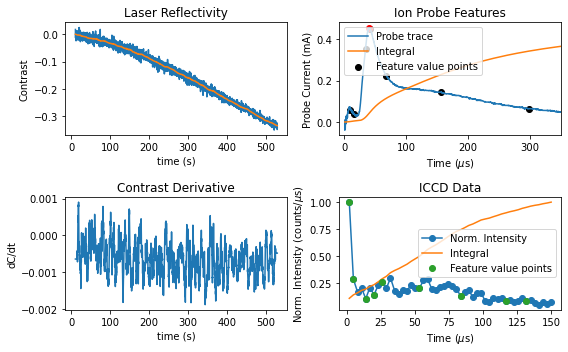

{'Pressure (Torr)': 150.0,
 'Gas 1': 'Ar',
 'Gas 1 Flowrate (sccm)': 5.0,
 'Gas 2': 'None',
 'Gas 2 Flowrate (sccm)': None,
 'Rep Rate 1': 2.0,
 'Aperture 1 Size X (mm)': 8.0,
 'Aperture 1 Size Y (mm)': 8.0,
 'Aperture 1 Area (mm^2)': 64.0,
 'Laser 1 Energy (mJ)': 28.8,
 'Rep Rate 2': None,
 'Aperture 2 Size X (mm)': None,
 'Aperture 2 Size Y (mm)': None,
 'Aperture 2 Area (mm^2)': None,
 'Laser 2 Energy (mJ)': None,
 'Number of pulses 2': None,
 'Substrate Temperature (C)': 600.0,
 'Target-Substrate Distance 1 (cm)': 5.0,
 'Target-Substrate Distance 2 (cm)': None,
 'Number of pulses': 1039,
 'Final LR Contrast': -0.3341809996524487,
 'Average LR Derivative': -0.0006408992919395799,
 'Stdev LR Derivative': 0.0004475550330770969,
 'Abs Max LR Derivative': 0.0018892816271769573,
 '0.5% TOF velocity (cm/us)': 0.49464098928276984,
 '0.5% probe current (mA)': 0.059879239286118005,
 '1% TOF velocity (cm/us)': 0.3131848418415284,
 '1% probe current (mA)': 0.039405880836834,
 '5% TOF velocity 

In [20]:
sample_files_directory = r"./"
absolute_path = os.path.abspath(sample_files_directory)
test_sample_path = r"050922 WSe2 Batch 3_1_sample_1_)_V2.h5"
test_sample = os.path.join(absolute_path,test_sample_path)

PLD_Sample_Features(test_sample,visualize=True)

# Testing Laser Reflectivity Features

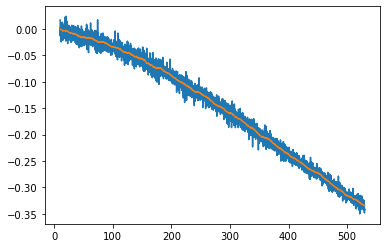

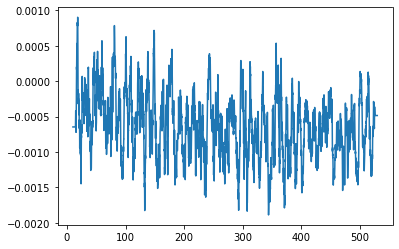

Derivative mean: -0.0006408992919395799
Derivative stdev: 0.0004475550330770969
Derivative abs. max: 0.0018892816271769573
Final LR contrast -0.3341809996524487
Number of pulses 1039


In [21]:
%matplotlib inline

sample = Sample(test_sample)

data, meta = sample.Laser_reflectivity()
########## Laser Reflectivity Features ##########
# get LR data
# average and minimum time step size, sometimes the sampling rate varies.
avg_t_step = np.diff(data[:,0]).mean()
min_t_step = np.diff(data[:,0]).min()

#Calculate the Contrast 
R0_avg = data[0:round(10/avg_t_step),1].mean() # average starting value during 10s before laser pulses
C = (data[:,1]-R0_avg)/R0_avg

# skip the 10.5s in the begining and end
points2skip = round(10.5/avg_t_step)
LR_t, LR_I = data[points2skip:-points2skip,0], C[points2skip:-points2skip]

# Get number of pulses from deposition time if needed.
number_of_pulses = round((LR_t[-1]-LR_t[0])*sample.Details['Rep Rate 1 (Hz)'])

# 10s filter for derivative
filtered = savgol_filter(LR_I,59*2+1,1,deriv=0,delta = avg_t_step)
derivative = savgol_filter(LR_I,59*2+1,1,deriv=1,delta = avg_t_step)
plt.plot(LR_t, LR_I)
plt.plot(LR_t, filtered)
plt.show()
plt.plot(LR_t, derivative)
plt.show()
print('Derivative mean:',derivative.mean())
print('Derivative stdev:',derivative.std())
print('Derivative abs. max:',np.abs(derivative).max())
print('Final LR contrast',filtered[-1])
print('Number of pulses',number_of_pulses)

# Testing Ion Probe Features

0.5% cumsum current TOF velocity is 0.49 cm/us
0.5% cumsum current is 0.06
1% cumsum current TOF velocity is 0.31 cm/us
1% cumsum current is 0.04
5% cumsum current TOF velocity is 0.14 cm/us
5% cumsum current is 0.35
10% cumsum current TOF velocity is 0.12 cm/us
10% cumsum current is 0.45
25% cumsum current TOF velocity is 0.07 cm/us
25% cumsum current is 0.22
50% cumsum current TOF velocity is 0.03 cm/us
50% cumsum current is 0.14
75% cumsum current TOF velocity is 0.02 cm/us
75% cumsum current is 0.06
90% cumsum current TOF velocity is 0.01 cm/us
90% cumsum current is 0.02
95% cumsum current TOF velocity is 0.01 cm/us
95% cumsum current is 0.01
Integrated current (C): 5.751063932704105e-08
Ion probe Peak TOF velocity: 0.11825912961210974
Ion probe Peak current (mA): 0.45575859174884


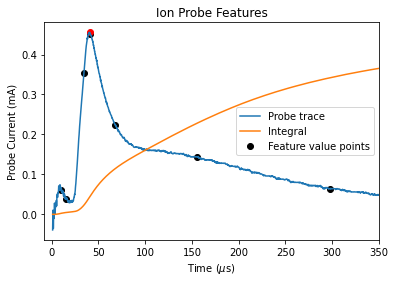

In [22]:
%matplotlib inline

IP_data, meta = Sample(test_sample).Ion_probe()

Resistance = meta['Resistance (ohms)']
TP_d = meta['Target-Probe Distance (mm)']*1e-3

# get FFT filtered IP data in microseconds
IP_t, IP_Ifilt = IP_data[:,1], IP_data[:,3]/Resistance

#start time to cut off weird fast pulses and FFT filtering end effects
t_step = np.diff(IP_t)[0]
t_start = 1e-6
t_end = IP_t[-1]-50e-6
time_bounds = (IP_t>t_start)&(IP_t<t_end)

integrated_probe_current = np.trapz(IP_Ifilt[time_bounds], IP_t[time_bounds])
current_sum = IP_Ifilt[time_bounds].sum()
ion_cumsum = IP_Ifilt[time_bounds].cumsum()

percent_current_labels = ['0.5%', '1%', '5%', '10%', '25%', '50%','75%','90%','95%']
percents = np.array([0.5,1,5,10,25,50,75,90,95])/100

time_points = np.zeros_like(percents)
current_points = np.zeros_like(percents)
TOF_velocities = np.zeros_like(percents)

for i in range(len(percents)):
    time_points[i] = IP_t[time_bounds][find_nearest(ion_cumsum,percents[i]*current_sum,index=True)]
    current_points[i] = IP_Ifilt[time_bounds][find_nearest(ion_cumsum,percents[i]*current_sum,index=True)]
    TOF_velocities[i] = (TP_d*1e2)/(time_points[i]*1e6)
    print('{} cumsum current TOF velocity is {:.2f} cm/us'.format(percent_current_labels[i], TOF_velocities[i]))
    print('{} cumsum current is {:.2f}'.format(percent_current_labels[i], current_points[i]*1e3))

plt.plot(IP_t[time_bounds]*1e6,IP_Ifilt[time_bounds]*1e3,label='Probe trace')
plt.plot(IP_t[time_bounds]*1e6, ion_cumsum/max(ion_cumsum)*max(IP_Ifilt)*1e3,label='Integral')
plt.scatter(time_points*1e6, current_points*1e3,c='k',label='Feature value points')
plt.scatter(IP_t[time_bounds][IP_Ifilt[time_bounds].argmax()]*1e6,IP_Ifilt[time_bounds].max()*1e3,c='r')
plt.xlim(-8,350)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Probe Current (mA)')
plt.title('Ion Probe Features')
plt.legend()

print('Integrated current (C):',integrated_probe_current)
print('Ion probe Peak TOF velocity:',(TP_d*1e2)/(IP_t[time_bounds][IP_Ifilt[time_bounds].argmax()]*1e6))
print('Ion probe Peak current (mA):',IP_Ifilt[time_bounds].max()*1e3)

# Testing ICCD Image Features

In [23]:
from tqdm import trange, tqdm
from sklearn.feature_extraction import image
from sklearn.utils.extmath import randomized_svd

def clean_svd(im, pixel_size=1, source_size=5):
    """De-noising of image by using first component of single value decomposition"""
    patch_size = int(source_size/pixel_size)
    if patch_size < 3:
        patch_size = 3
    patches = image.extract_patches_2d(im, (patch_size, patch_size))
    patches = patches.reshape(patches.shape[0], patches.shape[1]*patches.shape[2])

    num_components = 32

    u, s, v = randomized_svd(patches, num_components)
    u_im_size = int(np.sqrt(u.shape[0]))
    reduced_image = u[:, 0].reshape(u_im_size, u_im_size)
    reduced_image = reduced_image/reduced_image.sum()*im.sum()

    return reduced_image

(908, 958) (413, 463)


<ipython-input-24-43c216f7e8a7>:32: RuntimeWarning: invalid value encountered in log
  ax.pcolormesh(X,Y,np.log(d_temp))
<ipython-input-24-43c216f7e8a7>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X,Y,np.log(d_temp))


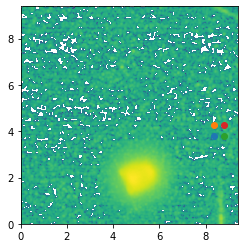

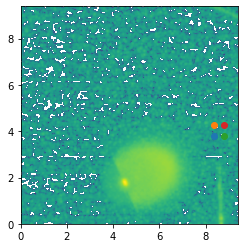

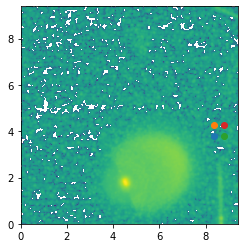

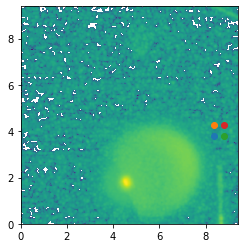

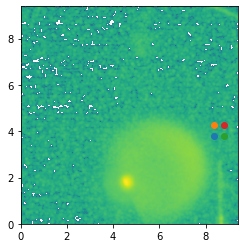

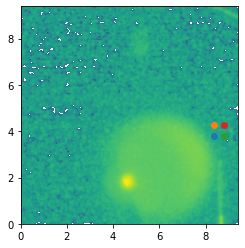

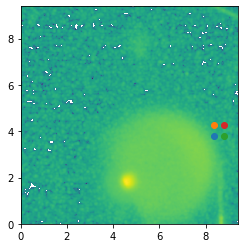

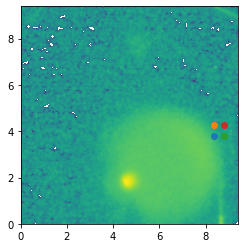

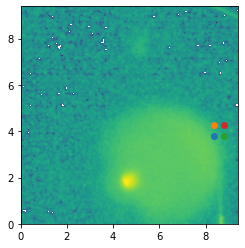

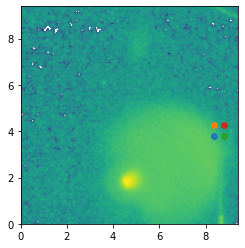

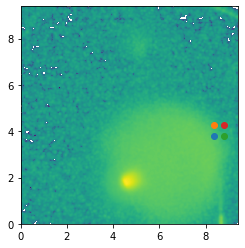

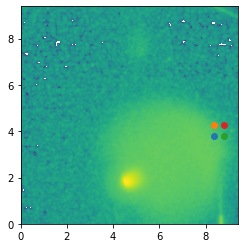

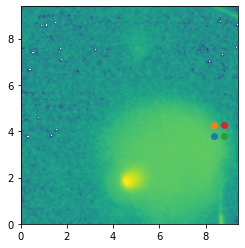

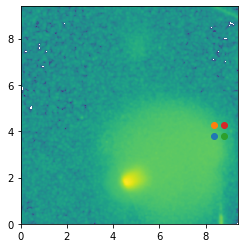

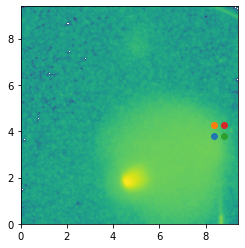

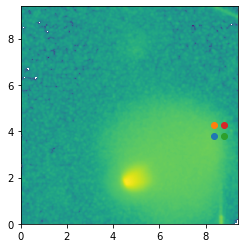

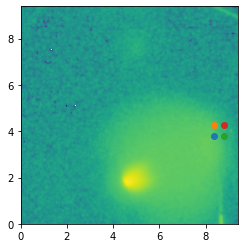

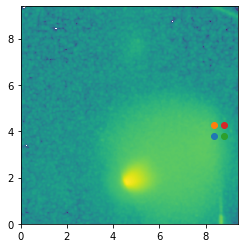

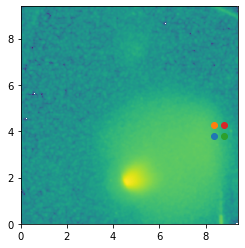

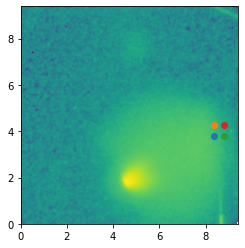

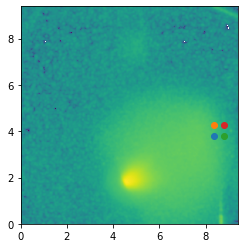

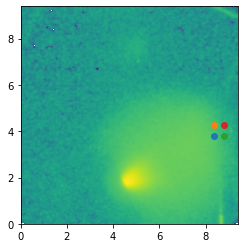

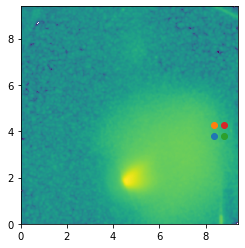

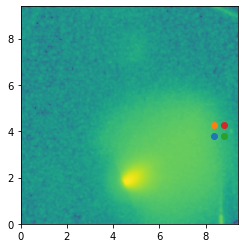

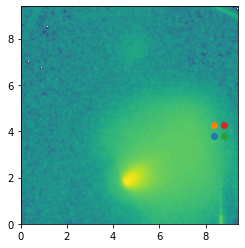

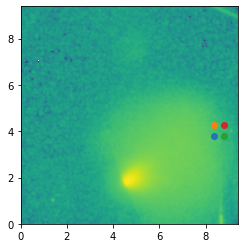

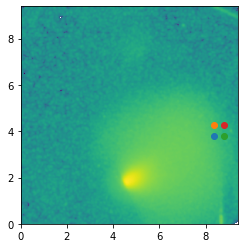

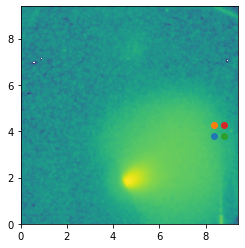

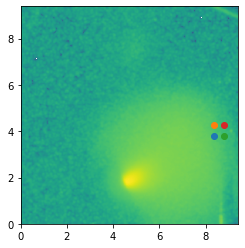

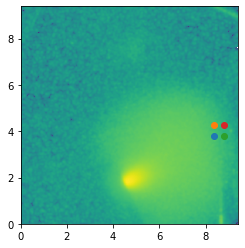

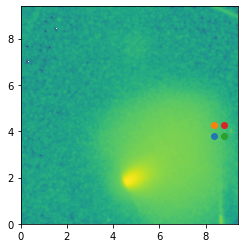

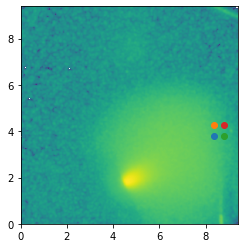

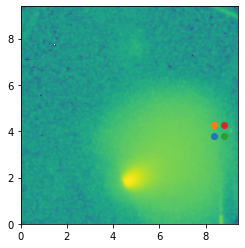

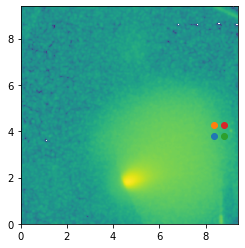

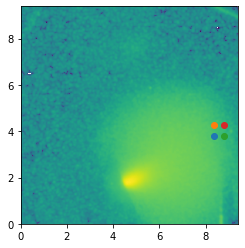

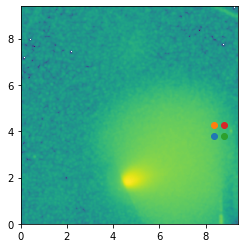

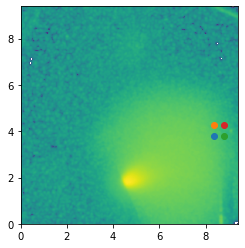

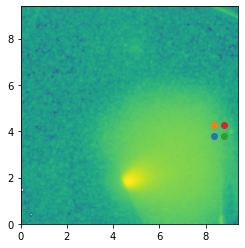

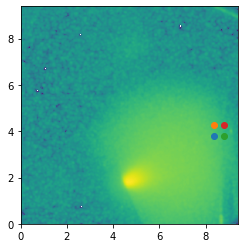

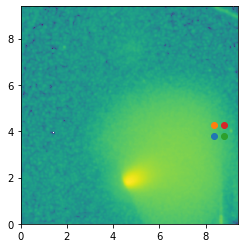

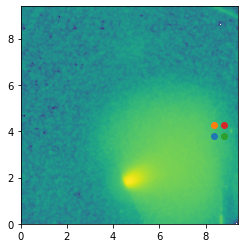

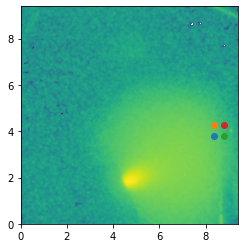

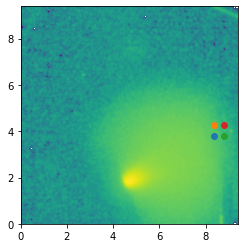

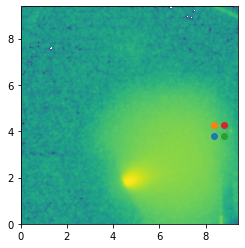

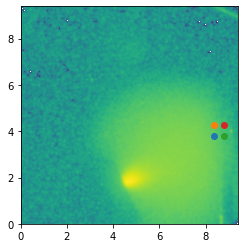

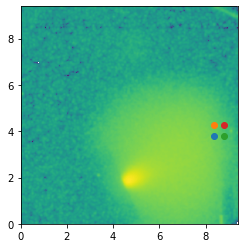

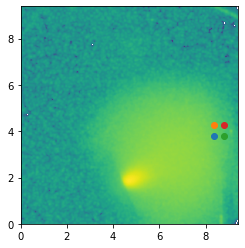

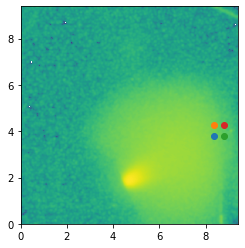

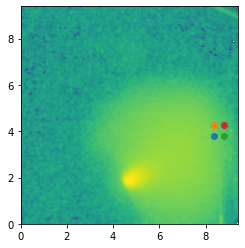

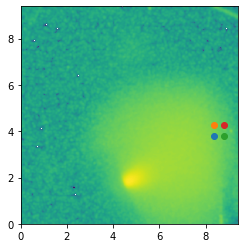

In [24]:
%matplotlib inline

data, meta = Sample(test_sample).ICCD_images()
fstop=meta['f-stop']
delays = meta['Delay sequence (ns)']
gates = meta['Gate sequence (ns)']
n_images = len(delays)

box_size = (50,50)
H_shift = 33

integration_box_x = int(substrate_location_pix[0]-box_size[0]-H_shift), int(substrate_location_pix[0]-H_shift)
integration_box_y = int(substrate_location_pix[1]-box_size[1]/2), int(substrate_location_pix[1]+box_size[1]/2)

print(integration_box_x, integration_box_y)

max_bounds = 1024/ICCD_pixel_per_cm
X,Y = np.linspace(0,max_bounds,num=1024),np.linspace(0,max_bounds,num=1024)

#fig,ax = plt.subplots()
#ax.pcolormesh(X,Y,np.log(np.flipud(data[:,:,20])))
#ax.set_aspect('equal', adjustable='box')
#ax.scatter(X[substrate_location_pix[0]], Y[586])

temporal_data = np.zeros_like(delays)
gauss_filtered = ndimage.gaussian_filter(data,sigma=(4,4,0),order=0)

for i in range(n_images):
    #svd_cleaned = clean_svd(gauss_filtered[:,:,i])
    d_temp = gauss_filtered[:,:,i]
    fig,ax = plt.subplots()
    ax.pcolormesh(X,Y,np.log(d_temp))
    ax.set_aspect('equal', adjustable='box')
    ax.scatter(X[integration_box_x[0]], Y[integration_box_y[0]])
    ax.scatter(X[integration_box_x[0]], Y[integration_box_y[1]])
    ax.scatter(X[integration_box_x[1]], Y[integration_box_y[0]])
    ax.scatter(X[integration_box_x[1]], Y[integration_box_y[1]])
    plt.show()
    #cleaned_image = clean_svd(data[:,:,i])
    #fig,ax = plt.subplots()
    #ax.pcolormesh(gauss_filtered[integration_box_x[0]:integration_box_x[1],integration_box_y[0]:integration_box_y[1]])
    #ax.set_aspect('equal', adjustable='box')
    #plt.show()
    temporal_data[i] = (d_temp[integration_box_x[0]:integration_box_x[1],integration_box_y[0]:integration_box_y[1]].mean())*(fstop**2/gates[i])

10% cumsum Intensity TOF velocity is 2.40 cm/us
10% cumsum Intensity is 662.72
15% cumsum Intensity TOF velocity is 0.96 cm/us
15% cumsum Intensity is 190.93
20% cumsum Intensity TOF velocity is 0.34 cm/us
20% cumsum Intensity is 71.79
25% cumsum Intensity TOF velocity is 0.24 cm/us
25% cumsum Intensity is 95.78
30% cumsum Intensity TOF velocity is 0.18 cm/us
30% cumsum Intensity is 172.99
50% cumsum Intensity TOF velocity is 0.09 cm/us
50% cumsum Intensity is 134.83
75% cumsum Intensity TOF velocity is 0.06 cm/us
75% cumsum Intensity is 89.90
90% cumsum Intensity TOF velocity is 0.04 cm/us
90% cumsum Intensity is 59.02
95% cumsum Intensity TOF velocity is 0.04 cm/us
95% cumsum Intensity is 56.01
Peak intensity value: 662.7163555028607 
Peak intensity TOF velocity: 2.4
Integrated Intensity: 16858.074866329152


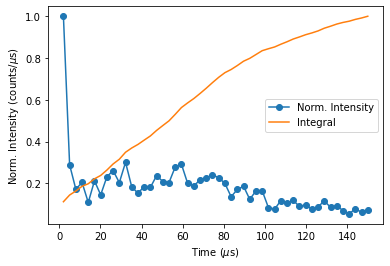

In [25]:
integrated_temporal_intensity = np.trapz(temporal_data, delays)
temporal_intensity_sum = temporal_data.sum()
temporal_intensity_cumsum =temporal_data.cumsum()

percent_intensity_labels = ['10%','15%','20%','25%','30%','50%','75%','90%','95%']
percents = np.array([10,15,20,25,30,50,75,90,95])/100

time_points = np.zeros_like(percents)
intenisty_points = np.zeros_like(percents)
TOFimage_velocities = np.zeros_like(percents)

for i in range(len(percents)):
    time_points[i] = delays[find_nearest(temporal_intensity_cumsum,percents[i]*temporal_intensity_sum,index=True)]
    intenisty_points[i] = temporal_data[find_nearest(temporal_intensity_cumsum,percents[i]*temporal_intensity_sum,index=True)]
    TOFimage_velocities[i] = (TP_d*1e2)/(time_points[i])
    print('{} cumsum Intensity TOF velocity is {:.2f} cm/us'.format(percent_intensity_labels[i], TOFimage_velocities[i]))
    print('{} cumsum Intensity is {:.2f}'.format(percent_intensity_labels[i], intenisty_points[i]))
    
fig, ax = plt.subplots()
ax.plot(delays,temporal_data/temporal_data.max(),'o-',label='Norm. Intensity')
ax.plot(delays,temporal_intensity_cumsum/temporal_intensity_cumsum.max(),label='Integral')
ax.legend()
ax.set_ylabel('Norm. Intensity (counts/$\mu$s)')
ax.set_xlabel('Time ($\mu$s)')

print('Peak intensity value: {} '.format(temporal_data.max()))
print('Peak intensity TOF velocity: {}'.format((TP_d*1e2)/delays[temporal_data.argmax()]))
print('Integrated Intensity: {}'.format(integrated_temporal_intensity))

(0.0, 150.0)

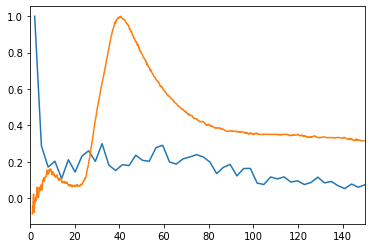

In [26]:
plt.plot(delays,temporal_data/temporal_data.max())
plt.plot(IP_t[time_bounds]*1e6,IP_Ifilt[time_bounds]/IP_Ifilt[time_bounds].max())
plt.xlim(0,150)

# Useage example

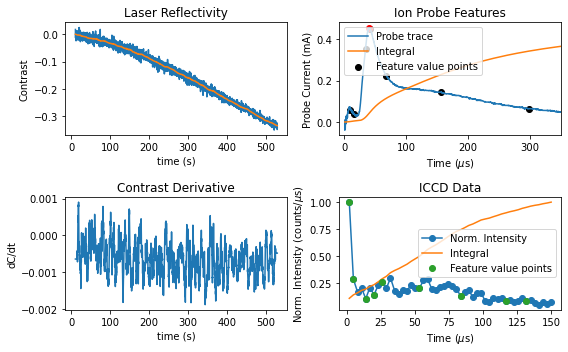

{'Pressure (Torr)': 150.0,
 'Gas 1': 'Ar',
 'Gas 1 Flowrate (sccm)': 5.0,
 'Gas 2': 'None',
 'Gas 2 Flowrate (sccm)': None,
 'Rep Rate 1': 2.0,
 'Aperture 1 Size X (mm)': 8.0,
 'Aperture 1 Size Y (mm)': 8.0,
 'Aperture 1 Area (mm^2)': 64.0,
 'Laser 1 Energy (mJ)': 28.8,
 'Rep Rate 2': None,
 'Aperture 2 Size X (mm)': None,
 'Aperture 2 Size Y (mm)': None,
 'Aperture 2 Area (mm^2)': None,
 'Laser 2 Energy (mJ)': None,
 'Number of pulses 2': None,
 'Substrate Temperature (C)': 600.0,
 'Target-Substrate Distance 1 (cm)': 5.0,
 'Target-Substrate Distance 2 (cm)': None,
 'Number of pulses': 1039,
 'Final LR Contrast': -0.3341809996524487,
 'Average LR Derivative': -0.0006408992919395799,
 'Stdev LR Derivative': 0.0004475550330770969,
 'Abs Max LR Derivative': 0.0018892816271769573,
 '0.5% TOF velocity (cm/us)': 0.49464098928276984,
 '0.5% probe current (mA)': 0.059879239286118005,
 '1% TOF velocity (cm/us)': 0.3131848418415284,
 '1% probe current (mA)': 0.039405880836834,
 '5% TOF velocity 

In [27]:
import PLD_Features_Generator as PLD
import os

sample_files_directory = r"./"
absolute_path = os.path.abspath(sample_files_directory)
test_sample_path = r"050922 WSe2 Batch 3_1_sample_1_)_V2.h5"
test_sample = os.path.join(absolute_path,test_sample_path)

PLD_Sample_Features(test_sample,visualize=True)